In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model,Sequential
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import scikitplot as skplt

In [2]:
def normalize(df_orig):
    x = df_orig.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_normalized = pd.DataFrame(x_scaled, columns = df_orig.columns, index= df_orig.index)
    return df_normalized


def data_preparation(df):
    proto = pd.get_dummies(df['proto'])
    land = df['sport'] == df['dport']
    land[land == True] = 1
    land[land == False] = 0
    category = df.pop('category')
    subcategory = df.pop('subcategory')
    attack = df.pop('attack')
    category = pd.get_dummies(category)
    df[proto.columns] = proto
    df['land'] = land
    state = pd.get_dummies(df['state'])
    df[state.columns] = state
    
    del(df['pkSeqID'])
    del(df['seq'])
    del(df['stime'])
    del(df['flgs'])
    del(df['smac'])
    del(df['dmac'])
    del(df['soui'])
    del(df['doui'])
    del(df['sco'])
    del(df['dco'])
    del(df['proto'])
    del(df['saddr'])
    del(df['daddr'])
    del(df['dport'])
    del(df['sport'])
    del(df['state'])
    
    df = normalize(df)
    df = df.astype(np.float32)
    return df, category

In [3]:
file_path = r'C:\Users\Евгений\finaldatasets.csv'
df = pd.read_csv(file_path)

In [4]:
df, category = data_preparation(df)
df.head()

,pkts,bytes,ltime,dur,mean,stddev,sum,min,max,spkts,...,tcp,udp,land,CON,FIN,INT,NRS,REQ,RST,URP
0,0.000028,1.784838e-06,0.574316,1.049121e-02,0.000019,0.000053,7.936079e-08,0.000000,0.000056,0.000021,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000003,5.127442e-08,0.183705,7.013396e-08,0.000050,0.000000,7.079667e-08,0.000050,0.000050,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000022,2.749286e-06,0.574249,5.319137e-03,0.004040,0.008054,1.153072e-05,0.000023,0.008056,0.000017,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000022,2.350078e-06,0.574262,5.477234e-03,0.003188,0.006226,9.099085e-06,0.000082,0.006293,0.000017,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000000,1.220820e-08,0.000140,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
train_df, test_df = np.split(df, [int(.8*len(df))])
train_category = category.head(len(train_df))
test_category = category.loc[len(train_df):]

In [39]:
def print_stats(y_predicted_counts_proba_, y_test_, atk_norm=False, classes_=['positive', 'Negative']):
    y_test_ = np.argmax(y_test_.values, axis=1)
    if atk_norm:
        y_predicted_counts_proba, y_test, = merge(y_predicted_counts_proba_, y_test_)
    else:
        y_predicted_counts_proba, y_test = y_predicted_counts_proba_, y_test_
    
    y_predicted_counts = np.array(y_predicted_counts_proba).argmax(axis=-1)
    keys, vals = define_metrics(y_test, y_predicted_counts, y_predicted_counts_proba)
    stats = pd.DataFrame([[round(x, 3) if not type(x) == str else x for x in vals]], columns=keys, index=['    '])
    display(stats)
    
    fig_scale = 0.6 if atk_norm else 0.9
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[int(fig_scale * x) for x in (16, 7)])
    _ = skplt.metrics.plot_roc(y_test, y_predicted_counts_proba, figsize=(int(14*0.7), int(10*0.7)), plot_micro=False, plot_macro=False, ax=axs)
    _ = plot_confusion_matrix(y_test_, np.argmax(y_predicted_counts_proba_, axis=1), classes = classes_, normalize=False)
    plt.show()

In [45]:
def train(gan, discriminator, generator, df, epochs=1, batch_size=128):
    
    batch_count = len(df) // batch_size
    history_dis =[]
    history_gen = []
    for e in range(1, epochs+1):
        for _ in tqdm(range(batch_count)):
            noise = np.random.uniform(0, 1, size=[batch_size, 100])
            real_packets = df.loc[np.random.randint(0, len(df), size= batch_size)]

            generated_packets = generator.predict(noise)
            X = np.concatenate([real_packets, generated_packets])

            y_dis = np.ones(2 * batch_size)
            y_dis[batch_size:] = 0

            discriminator.trainable = True
            history_dis.append(discriminator.train_on_batch(X, y_dis))

            noise = np.random.uniform(0, 1, size=[batch_size, 100])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            history_gen.append(gan.train_on_batch(noise, y_gen))
        print('-'*15, 'Epoch %d' % e, '-'*15)
    return history_dis, history_gen

In [46]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=100)
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan


In [ ]:
dis_dos = keras.Sequential([
    Dense(31, activation='relu'),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])
dis_dos.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

gen_dos = keras.Sequential([
    Dense(100, activation='relu'),
    Dense(76, activation='relu'),
    Dense(31, activation='sigmoid')
])
gen_dos.compile(optimizer='adam', loss='binary_crossentropy')

gan_dos = create_gan(dis_dos,gen_dos)


h_dis_dos, h_gen_dos = train(gan_dos, dis_dos, gen_dos, train_df.loc[train_category['DoS'] == 1].reset_index(drop=True), 100)

plt.title('h_dis_dos: loss')
plt.plot([h_dis_dos[y][0] for y in range(len(h_dis_dos))])
plt.show()

plt.title('h_dis_dos: acc')
plt.plot([h_dis_dos[y][1] for y in range(len(h_dis_dos))])
plt.show()

plt.title('h_gen_dos: loss')
plt.plot(h_gen_dos)
plt.show()

In [17]:
test_df = test_df.reset_index(drop=True)
test_category = test_category.reset_index(drop=True)
test_dos = test_df.loc[test_category['DoS'] == 1]

99/99 [==============================] - 0s 1ms/step - loss: 0.6182 - accuracy: 0.6824
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.843


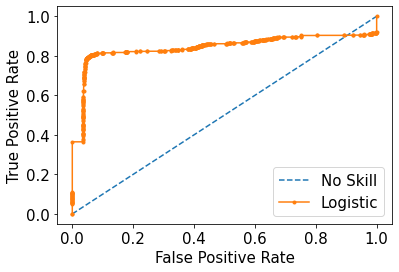

Accuracy: 0.6823640960809102
Precision: 0.8057595670660997
Recall: 0.6823640960809102
F-score: 0.6467208562371353
MСС: 0.4722692751644965
ROC AUC: 0.8425835209955232
Log Loss: 0.6181837618695372


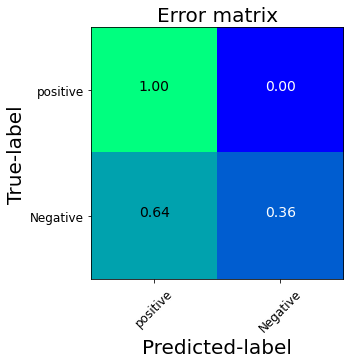

In [154]:
size= len(test_dos)
noise = np.random.uniform(0, 1, size=[size, 100])
generated_packets = gen_dos.predict(noise)
real_packets = test_dos[:size]
X1 = np.concatenate([real_packets, generated_packets])
y_dis1 = np.ones(2 * size)
y_dis1[size:] = 0
dis_dos.evaluate(X1, y_dis1)
roc_calc(dis_dos, X1, y_dis1)


### FINAL CHECK FOR DOS DISCRIMINATOR
y_predicted_proba = dis_dos.predict(X1)
stat_name, stat_value = define_metrics(y_dis1, np.round(y_predicted_proba), y_predicted_proba)
for i in range(len(stat_name)):
    print(stat_name[i] + ':', stat_value[i])
    

plot_confusion_matrix(y_dis1, np.round(dis_dos.predict(X1)))
plt.show()

In [ ]:
dis_normal = keras.Sequential([
    Dense(31, activation='relu'),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])
dis_normal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

gen_normal = keras.Sequential([
    Dense(100, activation='relu'),
    Dense(76, activation='relu'),
    Dense(31, activation='sigmoid')
])
gen_normal.compile(optimizer='adam', loss='binary_crossentropy')

gan_normal = create_gan(dis_normal,gen_normal)


h_dis_normal, h_gen_normal = train(gan_normal, dis_normal, gen_normal, train_df.loc[train_category['Normal'] == 1].reset_index(drop=True), 100)

plt.title('h_dis_normal: loss')
plt.plot([h_dis_normal[y][0] for y in range(len(h_dis_normal))])
plt.show()

plt.title('h_dis_normal: acc')
plt.plot([h_dis_normal[y][1] for y in range(len(h_dis_normal))])
plt.show()

plt.title('h_gen_normal: loss')
plt.plot(h_gen_normal)
plt.show()


test_df = test_df.reset_index(drop=True)
test_category = test_category.reset_index(drop=True)
test_normal = test_df.loc[test_category['Normal'] == 1]

size= len(test_normal)
noise = np.random.uniform(0, 1, size=[size, 100])
generated_packets = gen_normal.predict(noise)
real_packets = test_normal[:size]
X1 = np.concatenate([real_packets, generated_packets])
y_dis1 = np.ones(2 * size)
y_dis1[size:] = 0
dis_normal.evaluate(X1, y_dis1)
roc_calc(dis_normal, X1, y_dis1)

### FINAL CHECK FOR NORMAL DISCRIMINATOR
y_predicted_proba = dis_normal.predict(X1)
stat_name, stat_value = define_metrics(y_dis1, np.round(y_predicted_proba), y_predicted_proba)
for i in range(len(stat_name)):
    print(stat_name[i] + ':', stat_value[i])
    

plot_confusion_matrix(y_dis1, np.round(dis_normal.predict(X1)))
plt.show()

In [ ]:
dis_theft = keras.Sequential([
    Dense(31, activation='relu'),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])
dis_theft.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

gen_theft = keras.Sequential([
    Dense(100, activation='relu'),
    Dense(76, activation='relu'),
    Dense(31, activation='sigmoid')
])
gen_theft.compile(optimizer='adam', loss='binary_crossentropy')

gan_theft = create_gan(dis_theft,gen_theft)


h_dis_theft, h_gen_theft = train(gan_theft, dis_theft, gen_theft, train_df.loc[train_category['Theft'] == 1].reset_index(drop=True), 100)

plt.title('h_dis_theft: loss')
plt.plot([h_dis_theft[y][0] for y in range(len(h_dis_theft))])
plt.show()

plt.title('h_dis_theft: acc')
plt.plot([h_dis_theft[y][1] for y in range(len(h_dis_theft))])
plt.show()

plt.title('h_gen_theft: loss')
plt.plot(h_gen_theft)
plt.show()


test_df = test_df.reset_index(drop=True)
test_category = test_category.reset_index(drop=True)
test_theft = test_df.loc[test_category['Theft'] == 1]

size= len(test_theft)
noise = np.random.uniform(0, 1, size=[size, 100])
generated_packets = gen_theft.predict(noise)
real_packets = test_theft[:size]
X1 = np.concatenate([real_packets, generated_packets])
y_dis1 = np.ones(2 * size)
y_dis1[size:] = 0
dis_theft.evaluate(X1, y_dis1)
roc_calc(dis_theft, X1, y_dis1)


### FINAL CHECK FOR THEFT DISCRIMINATOR
y_predicted_proba = dis_theft.predict(X1)
stat_name, stat_value = define_metrics(y_dis1, np.round(y_predicted_proba), y_predicted_proba)
for i in range(len(stat_name)):
    print(stat_name[i] + ':', stat_value[i])
    

plot_confusion_matrix(y_dis1, np.round(dis_theft.predict(X1)))
plt.show()

In [ ]:
dis_rec = keras.Sequential([
    Dense(31, activation='relu'),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])
dis_rec.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

gen_rec = keras.Sequential([
    Dense(100, activation='relu'),
    Dense(76, activation='relu'),
    Dense(31, activation='sigmoid')
])
gen_rec.compile(optimizer='adam', loss='binary_crossentropy')

gan_rec = create_gan(dis_rec, gen_rec)


h_dis_rec, h_gen_rec = train(gan_rec, dis_rec, gen_rec, train_df.loc[train_category['Reconnaissance'] == 1].reset_index(drop=True), 100)

plt.title('h_dis_rec: loss')
plt.plot([h_dis_rec[y][0] for y in range(len(h_dis_rec))])
plt.show()

plt.title('h_dis_rec: acc')
plt.plot([h_dis_rec[y][1] for y in range(len(h_dis_rec))])
plt.show()

plt.title('h_gen_rec: loss')
plt.plot(h_gen_rec)
plt.show()


test_df = test_df.reset_index(drop=True)
test_category = test_category.reset_index(drop=True)
test_rec = test_df.loc[test_category['Reconnaissance'] == 1]

size= len(test_rec)
noise = np.random.uniform(0, 1, size=[size, 100])
generated_packets = gen_rec.predict(noise)
real_packets = test_rec[:size]
X1 = np.concatenate([real_packets, generated_packets])
y_dis1 = np.ones(2 * size)
y_dis1[size:] = 0
dis_rec.evaluate(X1, y_dis1)
roc_calc(dis_rec, X1, y_dis1)


### FINAL CHECK FOR RECON DISCRIMINATOR
y_predicted_proba = dis_rec.predict(X1)
stat_name, stat_value = define_metrics(y_dis1, np.round(y_predicted_proba), y_predicted_proba)
for i in range(len(stat_name)):
    print(stat_name[i] + ':', stat_value[i])
    

plot_confusion_matrix(y_dis1, np.round(dis_rec.predict(X1)))
plt.show()

In [48]:
def roc_calc(model, testX, testy):
    ns_probs = [0 for _ in range(len(testy))]
    lr_probs = model.predict_proba(testX)
    lr_probs = lr_probs[:]
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    
def define_metrics(y_test, y_predicted, y_predicted_proba):  
    # точность(precision)
    precision = metrics.precision_score(y_test, y_predicted, pos_label=None, average='weighted')             
    # Полнота (recall)
    recall = metrics.recall_score(y_test, y_predicted, pos_label=None, average='weighted') 
    # F-мера - среднее точности и полноты
    f1 = metrics.f1_score(y_test, y_predicted, pos_label=None, average='weighted')    
    # Accuracy – доля правильных ответов алгоритма
    accuracy = metrics.accuracy_score(y_test, y_predicted)
    #Коэффициент корреляции Мэтьюза: +1 представляет идеальное предсказание, 
    # 0 - среднее случайное предсказание и -1 - обратное предсказание. 
    matthews_corrcoef = metrics.matthews_corrcoef(y_test, y_predicted)
    try:
        #Вычислить площадь под кривой рабочих характеристик приемника (ROC AUC) по оценкам прогнозов.
        roc_auc_ovr = metrics.roc_auc_score(y_test, y_predicted_proba, average='weighted', multi_class='ovr')
    except ValueError:
        roc_auc_ovr = '-'
    
    try:
        #Функция правдоподобия отвечает на вопрос:«Насколько вероятным, по мнению модели,
        #  был фактически наблюдаемый набор результатов»
        log_loss = metrics.log_loss(y_test, y_predicted_proba)
    except ValueError:
        log_loss = '-'
    
    return ['Accuracy', 'Precision', 'Recall', 'F-score', 'MСС', 'ROC AUC', 'Log Loss'], \
           [accuracy,    precision,   recall,   f1,    matthews_corrcoef,    roc_auc_ovr, log_loss]


def merge(y_predicted_proba, y_test):
    norm_ind = list(label_encoder.transform(['Normal']))[0]
    y_test_2 = [0 if x == norm_ind else 1 for x in y_test]
    y_predicted_counts_2 = [[x[norm_ind], sum(x) - x[norm_ind]] for x in y_predicted_proba]
    return y_predicted_counts_2, y_test_2




def plot_confusion_matrix(Y, X, normalize=True,classes=['Positive', 'Negative'], cmap=plt.cm.winter):
    cm = confusion_matrix(Y, X)
    plt.figure(figsize=(7, 5))
    font = {'size' : 15}
    plt.rc('font', **font)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if np.isnan(cm[i, j]):
            cm[i, j] = 0.0
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix', fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12, rotation=45)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=14)
    
    plt.tight_layout()
    plt.ylabel('True-label', fontsize=20)
    plt.xlabel('Predicted-label', fontsize=20)

    return plt